In [1]:
import pandas as pd
import sqlite3

#Loading csv
df = pd.read_csv('../data/netflix.csv')

#Creates connection to SQLite database
conn = sqlite3.connect('kdot_netflix_data.db')

#Exports Dataframe to the database
df.to_sql('kdot_netflix_data', conn, if_exists='replace', index=False)

#Closes connection
# conn.close()


8807

In [2]:
#Preview the schema
pd.read_sql_query("PRAGMA table_info(kdot_netflix_data);", conn)

,cid,name,type,notnull,dflt_value,pk
0,0,show_id,TEXT,0,None,0
1,1,type,TEXT,0,None,0
2,2,title,TEXT,0,None,0
3,3,director,TEXT,0,None,0
4,4,cast,TEXT,0,None,0
5,5,country,TEXT,0,None,0
6,6,date_added,TEXT,0,None,0
7,7,release_year,INTEGER,0,None,0
8,8,rating,TEXT,0,None,0
9,9,duration,TEXT,0,None,0


In [3]:
#Counts the total records
pd.read_sql_query("SELECT COUNT(*) AS total_records FROM kdot_netflix_data;", conn)

,total_records
0,8807


In [4]:
#A look at the first five titles
pd.read_sql_query("""
                SELECT title, type, release_year
                FROM kdot_netflix_data
                LIMIT 5;
""", conn)

,title,type,release_year
0,Dick Johnson Is Dead,Movie,2020
1,Blood & Water,TV Show,2021
2,Ganglands,TV Show,2021
3,Jailbirds New Orleans,TV Show,2021
4,Kota Factory,TV Show,2021


In [5]:
#Count of movies vs tv shows
pd.read_sql_query("""
    SELECT type, COUNT(*) AS total
    FROM kdot_netflix_data
    GROUP BY type;
""", conn)

,type,total
0,Movie,6131
1,TV Show,2676


In [6]:
#Top 10 genres
pd.read_sql_query("""
    SELECT listed_in, COUNT(*) AS genre_count
    FROM kdot_netflix_data
    GROUP BY listed_in
    ORDER BY genre_count DESC
    LIMIT 10;
""", conn)

,listed_in,genre_count
0,"Dramas, International Movies",362
1,Documentaries,359
2,Stand-Up Comedy,334
3,"Comedies, Dramas, International Movies",274
4,"Dramas, Independent Movies, International Movies",252
5,Kids' TV,220
6,Children & Family Movies,215
7,"Children & Family Movies, Comedies",201
8,"Documentaries, International Movies",186
9,"Dramas, International Movies, Romantic Movies",180


### The genres data is not flatten so need to split and flatten data for more accurte showing

In [7]:
#Split and explode data
df_genres = df[['listed_in']].dropna()
df_genres['genre'] = df_genres['listed_in'].str.split(',')
df_genres = df_genres.explode('genre')

#Trimming the whitespace
df_genres['genre'] = df_genres['genre'].str.strip()

#Counting
genre_counts = df_genres['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

#New counting of top 10
genre_counts.head(10)

,genre,count
0,International Movies,2752
1,Dramas,2427
2,Comedies,1674
3,International TV Shows,1351
4,Documentaries,869
5,Action & Adventure,859
6,TV Dramas,763
7,Independent Movies,756
8,Children & Family Movies,641
9,Romantic Movies,616


### 🎬 Top Genres Breakdown (Normalized)

Initially, the dataset stored all genres in a single string, separated by commas (e.g., `"Dramas, International Movies"`). Counting these strings resulted in inaccurate genre distributions since combined categories were treated as unique.

To resolve this, I used `str.split()` and `explode()` to normalize the genres into individual rows. This allowed me to correctly calculate how often each distinct genre appears across the entire dataset.

The bar chart below highlights the **Top 10 genres** after this transformation, providing a much clearer view into the types of content available on Netflix.


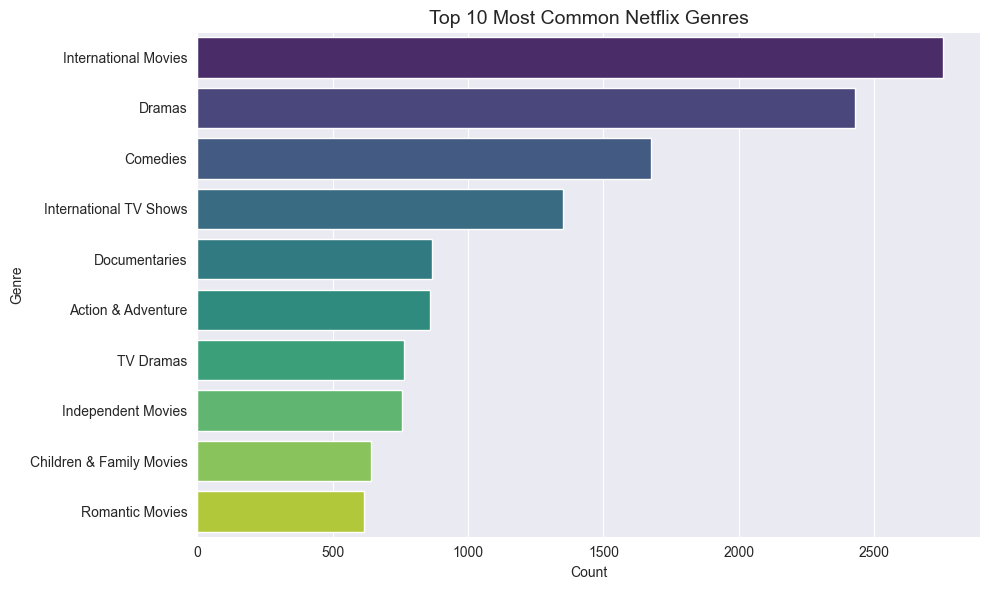

In [8]:
#Importing tools for visuals
import seaborn as sns
import matplotlib.pyplot as plt

#Setting plot style
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts.head(10), y='genre', x='count',hue='genre', palette='viridis')

#Adding labels and title
plt.title('Top 10 Most Common Netflix Genres', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Genre')
plt.tight_layout()
plt.savefig('../images/kdot_netflix_genres.png', bbox_inches='tight', dpi=300)
plt.show()

In [9]:
#Saves Genre table to SQLite
genre_counts.to_sql('normalized_genre_counts', conn, if_exists='replace', index=False)

42

In [10]:
#Querying titles per year
pd.read_sql_query("""
    SELECT strftime('%Y', date_added) AS year_added, COUNT(*) AS titles
    FROM kdot_netflix_data
    WHERE date_added IS NOT NULL
    GROUP BY year_added
    HAVING year_added IS NOT NULL
    ORDER BY year_added;
""", conn)

,year_added,titles


In [11]:
#Checking date-time format
pd.read_sql_query("""
    SELECT date_added
    FROM kdot_netflix_data
    WHERE date_added IS NOT NULL
    LIMIT 10;
""", conn)


,date_added
0,"September 25, 2021"
1,"September 24, 2021"
2,"September 24, 2021"
3,"September 24, 2021"
4,"September 24, 2021"
5,"September 24, 2021"
6,"September 24, 2021"
7,"September 24, 2021"
8,"September 24, 2021"
9,"September 24, 2021"


In [12]:
#Cleaning the dates in pandas
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['date_added'] = df['date_added'].dt.strftime('%Y-%m-%d')

In [18]:
#Reloading table
conn = sqlite3.connect('kdot_netflix_data.db')
df.to_sql('kdot_netflix_data', conn, if_exists='replace', index=False)

8807

In [19]:
#Re-trying the titles per year query
pd.read_sql_query("""
    SELECT strftime('%Y', date_added) AS year_added, COUNT(*) AS titles
    FROM kdot_netflix_data
    WHERE date_added IS NOT NULL
    GROUP BY year_added
    ORDER BY year_added;
""", conn)

,year_added,titles
0,2008,2
1,2009,2
2,2010,1
3,2011,13
4,2012,3
5,2013,10
6,2014,23
7,2015,73
8,2016,418
9,2017,1164


In [20]:
#Query showing Drama being anywhere in listed_in
pd.read_sql_query("""
    SELECT title, type, release_year
    FROM kdot_netflix_data
    WHERE listed_in LIKE '%Drama%'
    ORDER BY release_year DESC
    LIMIT 20;
""", conn)

,title,type,release_year
0,Blood & Water,TV Show,2021
1,Midnight Mass,TV Show,2021
2,The Starling,Movie,2021
3,Je Suis Karl,Movie,2021
4,Dear White People,TV Show,2021
5,Ankahi Kahaniya,Movie,2021
6,Squid Game,TV Show,2021
7,The Father Who Moves Mountains,Movie,2021
8,The Stronghold,Movie,2021
9,Castle and Castle,TV Show,2021


In [32]:
#Common Table Expression(CTE) for top countries by volume
sql = """
    WITH country_counts AS (
        SELECT country, COUNT(*) AS total
        FROM kdot_netflix_data
        WHERE country IS NOT NULL AND country <> ''
        GROUP BY country
    )
    SELECT country, total
    FROM country_counts
    ORDER BY total DESC
    LIMIT 10;
"""
country_top10 = pd.read_sql_query(sql, conn)

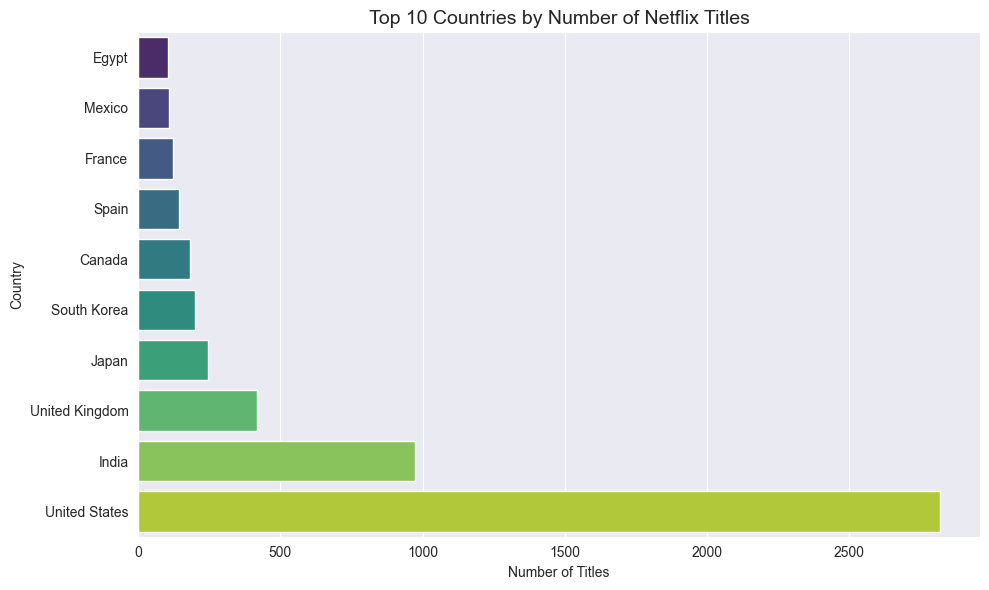

In [34]:
#Adding visual showing top 5

plot_df = country_top10.sort_values('total', ascending=True).copy()

plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, y='country', x='total',hue='country', palette='viridis')

#Adding labels and title
plt.title('Top 10 Countries by Number of Netflix Titles', fontsize=14)
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.tight_layout()
plt.savefig('../images/top_countries_by_volume.png', bbox_inches='tight', dpi=300)
plt.show()

In [22]:
#Ranking rating via window function
pd.read_sql_query("""
    SELECT rating, COUNT(*) AS cnt, RANK() OVER (ORDER BY COUNT(*) DESC) AS rnk
    FROM kdot_netflix_data
    GROUP BY rating
    ORDER BY cnt DESC;
""", conn)

,rating,cnt,rnk
0,TV-MA,3207,1
1,TV-14,2160,2
2,TV-PG,863,3
3,R,799,4
4,PG-13,490,5
5,TV-Y7,334,6
6,TV-Y,307,7
7,PG,287,8
8,TV-G,220,9
9,NR,80,10
